In [ ]:
# Jason Hemedinger
# Argonne National Laboratory

In [1]:
from pylab import *
import pyart, boto3, tempfile, os, shutil, datetime, matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import animation
from botocore.handlers import disable_signing
from tint import Cell_tracks
from tint import animate as tint_animate
from tint.visualization import embed_mp4_as_gif
from glob import glob


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119

2.2.2


In [2]:
def get_radar_scan(station='KLOT', date=None, key_index=-15):
    '''
    Function will pull the latest radar scan from any radar site using 
    Amazon S3.
    ----------
    Station = Four letter NEXRAD identifier
              Example: 'KEPZ'
    Date = default is none for current date, else enter date in format "YYYY/MM/DD"        
    Key_index = Number of keys you want pulled from most recent scan.
    Ex: key_index = -15 would pull ht most recent 15 scans
    '''
    
    #creating a bucket and a client to be able to pull data from AWS and setting 
    #it as unsigned
    bucket = 'noaa-nexrad-level2'
    s3 = boto3.resource('s3')
    s3.meta.client.meta.events.register('choose-signer.s3.*', disable_signing)
    
    #connects the bucket create above with radar data
    aws_radar = s3.Bucket(bucket)
    
    #setting the date and time to current.
    #this will allow for allow the current date's radar scands to be pulled
    if date == None:
        target_string = datetime.datetime.utcnow().strftime('%Y/%m/%d/'+station)
    else:
        target_string = date+'/'+station
        
    
    for obj in aws_radar.objects.filter(Prefix= target_string):
        '{0}:{1}'.format(aws_radar.name, obj.key)
    my_list_of_keys = [this_object.key for this_object in aws_radar.objects.filter(Prefix= target_string)]
    keys = my_list_of_keys[key_index:]
    print(keys)
    return aws_radar, keys

In [3]:
def new_directory(date = 'current', 
                  year = datetime.datetime.utcnow().strftime('%Y'), 
                  month = datetime.datetime.utcnow().strftime('%m'), 
                  day = datetime.datetime.utcnow().strftime('%d'), 
                  hour = datetime.datetime.utcnow().strftime('%H'), 
                  path = '/home/jhemedinger/suli_projects/chicago-nowcast/events'):
    
    if date == 'past':
        past_date = str(datetime.datetime(year, month, day).strftime('%Y_%m_%d'))
        out_dir_path = path+'/'+past_date
        event_date = str(datetime.datetime(year, month, day, hour).strftime('%Y%m%d-%H'))
    elif date == 'current':
        cur_date = str(datetime.datetime.utcnow().strftime('%Y_%m_%d'))
        out_dir_path = path+'/'+cur_date
        event_date = str(datetime.datetime.utcnow().strftime('%Y%m%d-%H'))
    out_dir = os.makedirs(out_dir_path, exist_ok=True)    
    out_path_dir = out_dir_path+'/'+event_date+'Z'
    out_path = os.makedirs(out_path_dir, exist_ok=True)
    print('current saving directory:', out_path_dir)
    return out_path_dir

In [4]:
#setting the radar site and which keys to pul.
aws_radar, keys = get_radar_scan('KLOT', '2018/06/26', -21)
out_path_dir = new_directory(date = 'past', year = 2018, month = 6, day = 26, hour = 21)

['2018/06/26/KLOT/KLOT20180626_213400_V06', '2018/06/26/KLOT/KLOT20180626_214020_V06', '2018/06/26/KLOT/KLOT20180626_214641_V06', '2018/06/26/KLOT/KLOT20180626_215303_V06', '2018/06/26/KLOT/KLOT20180626_215925_V06', '2018/06/26/KLOT/KLOT20180626_220546_V06', '2018/06/26/KLOT/KLOT20180626_221220_V06', '2018/06/26/KLOT/KLOT20180626_221854_V06', '2018/06/26/KLOT/KLOT20180626_222528_V06', '2018/06/26/KLOT/KLOT20180626_223205_V06', '2018/06/26/KLOT/KLOT20180626_223928_V06', '2018/06/26/KLOT/KLOT20180626_224650_V06', '2018/06/26/KLOT/KLOT20180626_225415_V06', '2018/06/26/KLOT/KLOT20180626_230137_V06', '2018/06/26/KLOT/KLOT20180626_230901_V06', '2018/06/26/KLOT/KLOT20180626_231625_V06', '2018/06/26/KLOT/KLOT20180626_232348_V06', '2018/06/26/KLOT/KLOT20180626_233110_V06', '2018/06/26/KLOT/KLOT20180626_233834_V06', '2018/06/26/KLOT/KLOT20180626_234558_V06', '2018/06/26/KLOT/KLOT20180626_235323_V06']
current saving directory: /home/jhemedinger/suli_projects/chicago-nowcast/events/2018_06_26/2018

In [ ]:
#animating using matplotlib and pyart
def animate(nframe):
    plt.clf()
    localfile = tempfile.NamedTemporaryFile()
    aws_radar.download_file(keys[nframe], localfile.name)
    radar = pyart.io.read(localfile.name)
    display = pyart.graph.RadarMapDisplay(radar)
    # Delete radar after use to save memory.
    del radar
    display.plot_ppi_map('reflectivity', sweep=0, resolution='l',
                         vmin=-8, vmax=64, mask_outside=False, 
                         fig=fig, width=350000, height=350000, 
                         cmap = pyart.graph.cm.LangRainbow12 )

    display.basemap.drawcounties()
    display.plot_point(-87.981810, 41.713969 , label_text='ANL', symbol='ko')
#    display.plot_point(-87.04361, 41.46361, label_text='VU', color='k')
#    ax = plt.gca()
#    ex = [-89., -87., 40.5, 42.7]
#    ax.set_extent(ex)
#    scale_bar_left(plt.gca(), linewidth=10, fs=15, col='black', length=40)
fig = plt.figure(figsize=(10, 8))

anim_klot = animation.FuncAnimation(fig, animate,
                                    frames=len(keys))
anim_klot.save(out_path_dir + '/reflectivity_animation.gif', 
               writer='imagemagick', fps=2)
plt.show()
plt.close()

In [ ]:
#turing the data into grid data and saving it to a folder
def get_grid(aws_radar, key):
    localfile = tempfile.NamedTemporaryFile()
    aws_radar.download_file(key, localfile.name)
    radar = pyart.io.read(localfile.name)
    grid = pyart.map.grid_from_radars(
            radar, grid_shape=(31, 401, 401),
            grid_limits=((0, 15000), (-200000, 200000), (-200000, 200000)),
            fields=['reflectivity'], gridding_algo='map_gates_to_grid',
            h_factor=0., nb=0.6, bsp=1., min_radius=200.)
    return grid

for num,key in enumerate(keys):
    print('saving grid', num)
    grid = get_grid(aws_radar, key)
    name = os.path.join(out_path_dir, 'grid_' + str(num).zfill(3) + '.nc')
    pyart.io.write_grid(name, grid)
    del grid

In [5]:
#files_2 = [os.path.join(out_dir, fn) for fn in os.listdir(out_dir)]
files = glob(out_path_dir + '/grid_*')
files.sort()

In [6]:
grid_gen = (pyart.io.read_grid(f) for f in files)
#grid_list = [pyart.io.read_grid(f) for f in files]

In [7]:
tracks_obj = Cell_tracks()
tracks_obj.params

{'FIELD_THRESH': 32,
 'FLOW_MARGIN': 10000,
 'GS_ALT': 1500,
 'ISO_SMOOTH': 3,
 'ISO_THRESH': 8,
 'MAX_DISPARITY': 999,
 'MAX_FLOW_MAG': 50,
 'MAX_SHIFT_DISP': 15,
 'MIN_SIZE': 8,
 'SEARCH_MARGIN': 4000}

In [8]:
tracks_obj.params['FIELD_THRESH']=35

In [9]:
tracks_obj.params

{'FIELD_THRESH': 35,
 'FLOW_MARGIN': 10000,
 'GS_ALT': 1500,
 'ISO_SMOOTH': 3,
 'ISO_THRESH': 8,
 'MAX_DISPARITY': 999,
 'MAX_FLOW_MAG': 50,
 'MAX_SHIFT_DISP': 15,
 'MIN_SIZE': 8,
 'SEARCH_MARGIN': 4000}

In [10]:
tracks_obj.get_tracks(grid_gen)

Writing tracks for scan 0
Writing tracks for scan 1
Writing tracks for scan 2
Writing tracks for scan 3
Writing tracks for scan 4
Writing tracks for scan 5
Writing tracks for scan 6
Writing tracks for scan 7
Writing tracks for scan 8
Writing tracks for scan 9
Writing tracks for scan 10
Writing tracks for scan 11
Writing tracks for scan 12
Writing tracks for scan 13
Writing tracks for scan 14
Writing tracks for scan 15
Writing tracks for scan 16
Writing tracks for scan 17
Writing tracks for scan 18
Writing tracks for scan 19
Writing tracks for scan 20


time elapsed 0.4 minutes


In [11]:
tracks_obj.tracks

time   grid_x   grid_y      lon      lat    area  \
scan uid                                                                   
0    0   2018-06-26 21:34:00  170.706  125.706 -88.4297  40.9384    17.0   
     1   2018-06-26 21:34:00  167.938  155.500 -88.4670  41.2081    48.0   
     2   2018-06-26 21:34:00    3.074  164.593 -90.4417  41.2655    27.0   
     3   2018-06-26 21:34:00    1.710  197.129 -90.4642  41.5529    31.0   
     4   2018-06-26 21:34:00   74.769  204.231 -89.5885  41.6306    13.0   
     5   2018-06-26 21:34:00  150.540  210.327 -88.6746  41.6929   150.0   
     6   2018-06-26 21:34:00   69.086  214.993 -89.6631  41.7286   267.0   
     7   2018-06-26 21:34:00  102.839  213.483 -89.2531  41.7154   118.0   
     8   2018-06-26 21:34:00  120.027  210.459 -89.0479  41.6904    37.0   
     9   2018-06-26 21:34:00  121.765  218.059 -89.0249  41.7625    17.0   
     10  2018-06-26 21:34:00   76.500  229.000 -89.5817  41.8556    10.0   
     11  2018-06-26 21:34:00  147.084  236.036 -88.7251  41.9264    83.0   
     12  2018-06-26 21:34:00  175.174  240.095 -88.3868  41.9638   367.0   
     13  2018-06-26 21:34:00   71.565  235.913 -89.6315  41.9179    23.0   
     14  2018-06-26 21:34:00  111.471  243.000 -89.1613  41.9861    34.0   
     15  2018-06-26 21:34:00   92.462  248.231 -89.3920  42.0287    13.0   
     16  2018-06-26 21:34:00   58.538  251.231 -89.7922  42.0505    13.0   
     17  2018-06-26 21:34:00  199.261  254.435 -88.0966  42.0901    23.0   
     18  2018-06-26 21:34:00  130.333  258.111 -88.9332  42.1229    18.0   
     19  2018-06-26 21:34:00   92.569  267.053 -89.3834  42.1997   262.0   
     20  2018-06-26 21:34:00  189.684  278.018 -88.2060  42.3059   948.0   
     21  2018-06-26 21:34:00  137.067  264.267 -88.8490  42.1775    15.0   
     22  2018-06-26 21:34:00    2.017  276.724 -90.4911  42.2720    58.0   
     23  2018-06-26 21:34:00  125.842  267.158 -88.9828  42.2035    19.0   
     24  2018-06-26 21:34:00   64.415  272.755 -89.7368  42.2492    53.0   
     25  2018-06-26 21:34:00  154.000  273.632 -88.6435  42.2686    19.0   
     26  2018-06-26 21:34:00  147.861  285.126 -88.7174  42.3671   151.0   
     27  2018-06-26 21:34:00  137.500  279.000 -88.8384  42.3125    12.0   
     28  2018-06-26 21:34:00   10.846  287.077 -90.3851  42.3641    13.0   
     29  2018-06-26 21:34:00   23.421  295.211 -90.2415  42.4388    19.0   
...                      ...      ...      ...      ...      ...     ...   
20   216 2018-06-26 23:53:23  108.671  237.697 -89.1847  41.9410    76.0   
     306 2018-06-26 23:53:23  221.273  234.909 -87.8306  41.9189    11.0   
     307 2018-06-26 23:53:23  197.875  241.250 -88.1086  41.9732     8.0   
     1   2018-06-26 23:53:23  188.074  247.722 -88.2297  42.0360    54.0   
     6   2018-06-26 23:53:23  163.745  290.341 -88.5229  42.4130  1609.0   
     286 2018-06-26 23:53:23  177.214  250.714 -88.3631  42.0628    14.0   
     287 2018-06-26 23:53:23  132.208  261.625 -88.9094  42.1591    24.0   
     251 2018-06-26 23:53:23  143.690  262.759 -88.7639  42.1690    29.0   
     270 2018-06-26 23:53:23  230.000  264.643 -87.7203  42.1884    56.0   
     159 2018-06-26 23:53:23   65.162  272.703 -89.7247  42.2494   111.0   
     308 2018-06-26 23:53:23  142.130  273.922 -88.7893  42.2678   115.0   
     309 2018-06-26 23:53:23  241.217  280.059 -87.5857  42.3228   203.0   
     164 2018-06-26 23:53:23  225.973  315.882 -87.7666  42.6472  1193.0   
     289 2018-06-26 23:53:23   80.625  292.250 -89.5342  42.4228    16.0   
     310 2018-06-26 23:53:23  189.769  297.346 -88.2064  42.4767    26.0   
     311 2018-06-26 23:53:23  197.545  298.182 -88.1088  42.4858    11.0   
     292 2018-06-26 23:53:23  178.511  302.589 -88.3407  42.5305    90.0   
     293 2018-06-26 23:53:23  187.556  303.889 -88.2309  42.5396     9.0   
     294 2018-06-26 23:53:23  132.880  319.640 -88.9040  42.6807    25.0   
     273 2018-06-26 23:53:23  269.054  335.393 -87.2386  42.8155   387.0

In [12]:
if os.path.exists(out_path_dir + '/tracks_animation.mp4'):
    print(out_path_dir + '/tracks_animation.mp4'
          + ' already exists, removing file')
    os.remove(out_path_dir + '/tracks_animation.mp4')

/home/jhemedinger/suli_projects/chicago-nowcast/events/2018_06_26/20180626-21Z/tracks_animation.mp4 already exists, removing file


In [13]:
grid_gen = (pyart.io.read_grid(f) for f in files)
tint_animate(tracks_obj, grid_gen, os.path.join(out_path_dir, 'tracks_animation'), tracers=True)

Animating 21 frames
Frame: 0
Frame: 1
Frame: 2
Frame: 3
Frame: 4
Frame: 5
Frame: 6
Frame: 7
Frame: 8
Frame: 9
Frame: 10
Frame: 11
Frame: 12
Frame: 13
Frame: 14
Frame: 15
Frame: 16
Frame: 17
Frame: 18
Frame: 19
Frame: 20


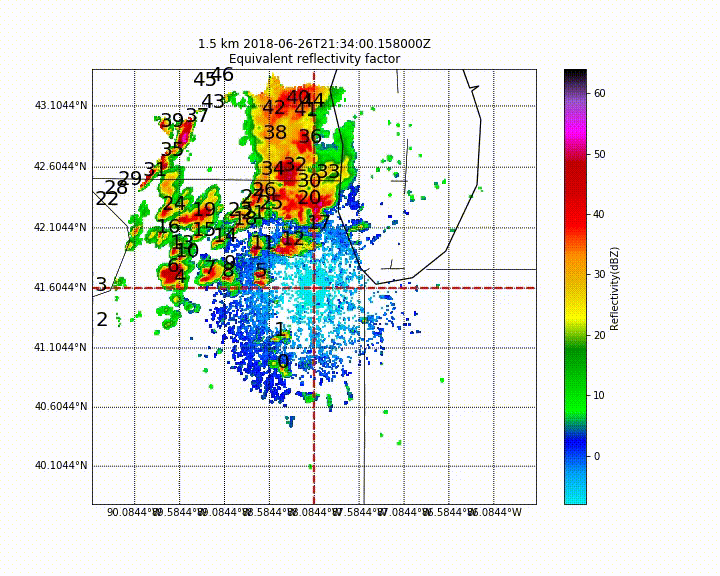

In [14]:
embed_mp4_as_gif(out_path_dir + '/tracks_animation.mp4')

In [15]:
cells = tracks_obj.tracks.groupby(level='uid')
for uid in cells:
    print(uid)

('0',                         time   grid_x   grid_y      lon      lat   area  \
scan uid                                                                  
0    0   2018-06-26 21:34:00  170.706  125.706 -88.4297  40.9384   17.0   
1    0   2018-06-26 21:40:20  173.074  128.389 -88.4060  40.9565   54.0   
2    0   2018-06-26 21:46:41  172.023  133.386 -88.4181  41.0014   88.0   
3    0   2018-06-26 21:53:03  174.324  137.833 -88.3945  41.0464  102.0   
4    0   2018-06-26 21:59:25  176.868  140.640 -88.3588  41.0735  136.0   
5    0   2018-06-26 22:05:46  180.615  144.054 -88.3112  41.1006  130.0   
6    0   2018-06-26 22:12:20  183.710  147.359 -88.2755  41.1276  145.0   
7    0   2018-06-26 22:18:54  187.077  156.864 -88.2399  41.2176  272.0   
8    0   2018-06-26 22:25:28  188.739  163.103 -88.2161  41.2716  426.0   
9    0   2018-06-26 22:32:05  193.157  172.507 -88.1683  41.3616  345.0   
10   0   2018-06-26 22:39:28  195.988  176.391 -88.1324  41.3886  327.0   
11   0   2018-06-26

('159',                         time  grid_x   grid_y      lon      lat   area  \
scan uid                                                                 
10   159 2018-06-26 22:39:28   8.208  240.081 -90.4061  41.9409  149.0   
11   159 2018-06-26 22:46:50   9.360  240.423 -90.3940  41.9411  175.0   
12   159 2018-06-26 22:54:15  13.847  241.930 -90.3342  41.9603  215.0   
13   159 2018-06-26 23:01:37  22.858  250.376 -90.2278  42.0343  330.0   
14   159 2018-06-26 23:09:01  30.210  253.419 -90.1439  42.0628  105.0   
15   159 2018-06-26 23:16:25  34.388  254.027 -90.0958  42.0726  147.0   
16   159 2018-06-26 23:23:48  39.059  255.343 -90.0355  42.0826  102.0   
17   159 2018-06-26 23:31:10  51.847  261.514 -89.8798  42.1481  144.0   
18   159 2018-06-26 23:38:34  54.531  264.367 -89.8439  42.1667  147.0   
19   159 2018-06-26 23:45:58  62.544  270.333 -89.7482  42.2220   90.0   
20   159 2018-06-26 23:53:23  65.162  272.703 -89.7247  42.2494  111.0   

             vol        max  

('24',                         time  grid_x   grid_y      lon      lat  area    vol  \
scan uid                                                                       
0    24  2018-06-26 21:34:00  64.415  272.755 -89.7368  42.2492  53.0  199.5   
1    24  2018-06-26 21:40:20  68.000  278.453 -89.6894  42.2948  64.0  194.5   
2    24  2018-06-26 21:46:41  71.625  282.922 -89.6418  42.3404  64.0  204.0   
3    24  2018-06-26 21:53:03  75.870  286.891 -89.5940  42.3770  46.0  145.5   

                max  max_alt  isolated  
scan uid                                
0    24   50.991253      7.0     False  
1    24   47.248001      6.0     False  
2    24   47.986687      6.0     False  
3    24   45.949345      6.0     False  )
('240',                         time   grid_x   grid_y      lon      lat   area  \
scan uid                                                                  
16   240 2018-06-26 23:23:48  246.919  333.243 -87.5084  42.7991   37.0   
17   240 2018-06-26 23:31:10  25

20   305  1046.0  58.021599      6.5     False  )
('306',                         time   grid_x   grid_y      lon      lat  area   vol  \
scan uid                                                                       
20   306 2018-06-26 23:53:23  221.273  234.909 -87.8306  41.9189  11.0  18.0   

                max  max_alt  isolated  
scan uid                                
20   306  51.697491      6.0     False  )
('307',                         time   grid_x  grid_y      lon      lat  area  vol  \
scan uid                                                                     
20   307 2018-06-26 23:53:23  197.875  241.25 -88.1086  41.9732   8.0  5.0   

                max  max_alt  isolated  
scan uid                                
20   307  38.297562      4.0     False  )
('308',                         time  grid_x   grid_y      lon      lat   area    vol  \
scan uid                                                                        
20   308 2018-06-26 23:53:23  142.13  27

('9',                         time   grid_x   grid_y      lon      lat  area   vol  \
scan uid                                                                       
0    9   2018-06-26 21:34:00  121.765  218.059 -89.0249  41.7625  17.0  38.5   

                max  max_alt  isolated  
scan uid                                
0    9    44.755413      5.0     False  )
('90',                         time  grid_x   grid_y      lon      lat   area  \
scan uid                                                                 
5    90  2018-06-26 22:05:46  34.200  172.560 -90.0731  41.3445   25.0   
6    90  2018-06-26 22:12:20  37.000  175.576 -90.0380  41.3720   33.0   
7    90  2018-06-26 22:18:54  39.342  178.842 -90.0148  41.3994   38.0   
8    90  2018-06-26 22:25:28  39.500  181.597 -90.0037  41.4266   62.0   
9    90  2018-06-26 22:32:05  41.000  184.214 -89.9922  41.4448   42.0   
10   90  2018-06-26 22:39:28  43.241  187.556 -89.9692  41.4811   54.0   
11   90  2018-06-26 22:46:50  

In [16]:
tracks_obj.tracks.groupby(level='uid').size().sort_values(ascending=False)[:]

uid
0      21
1      21
32     21
6      21
37     19
90     16
11     16
22     13
19     13
8      13
146    12
147    12
116    12
55     11
159    11
164    11
3      10
66      9
23      8
7       8
40      8
192     8
136     8
189     8
130     7
14      7
64      7
48      6
31      6
138     6
       ..
71      1
177     1
209     1
252     1
300     1
174     1
173     1
172     1
301     1
170     1
296     1
295     1
83      1
190     1
208     1
206     1
205     1
204     1
203     1
202     1
201     1
78      1
288     1
29      1
290     1
79      1
195     1
291     1
80      1
59      1
Length: 315, dtype: int64

In [17]:
df_161 = pd.DataFrame(tracks_obj.tracks.xs('0', level='uid'))
lons, lats = np.array(df_161['lon']), np.array(df_161['lat'])
time = np.array(pd.to_datetime(df_161['time']))
print(df_161)

                    time   grid_x   grid_y      lon      lat   area     vol  \
scan                                                                          
0    2018-06-26 21:34:00  170.706  125.706 -88.4297  40.9384   17.0    33.5   
1    2018-06-26 21:40:20  173.074  128.389 -88.4060  40.9565   54.0   113.5   
2    2018-06-26 21:46:41  172.023  133.386 -88.4181  41.0014   88.0   201.5   
3    2018-06-26 21:53:03  174.324  137.833 -88.3945  41.0464  102.0   227.0   
4    2018-06-26 21:59:25  176.868  140.640 -88.3588  41.0735  136.0   366.0   
5    2018-06-26 22:05:46  180.615  144.054 -88.3112  41.1006  130.0   366.5   
6    2018-06-26 22:12:20  183.710  147.359 -88.2755  41.1276  145.0   381.0   
7    2018-06-26 22:18:54  187.077  156.864 -88.2399  41.2176  272.0   646.5   
8    2018-06-26 22:25:28  188.739  163.103 -88.2161  41.2716  426.0  1055.5   
9    2018-06-26 22:32:05  193.157  172.507 -88.1683  41.3616  345.0   853.0   
10   2018-06-26 22:39:28  195.988  176.391 -88.1324 

In [18]:
ts = pd.to_datetime(time[:11])
print(ts)

DatetimeIndex(['2018-06-26 21:34:00', '2018-06-26 21:40:20',
               '2018-06-26 21:46:41', '2018-06-26 21:53:03',
               '2018-06-26 21:59:25', '2018-06-26 22:05:46',
               '2018-06-26 22:12:20', '2018-06-26 22:18:54',
               '2018-06-26 22:25:28', '2018-06-26 22:32:05',
               '2018-06-26 22:39:28'],
              dtype='datetime64[ns]', freq=None)


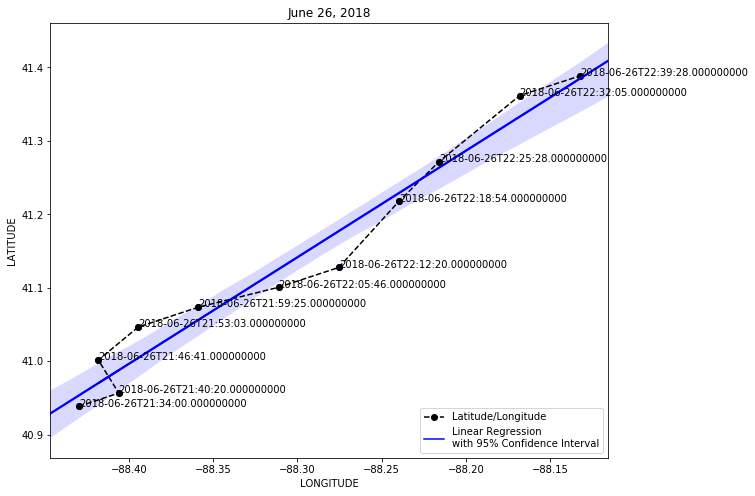

In [27]:
fit = polyfit(lons[:11],lats[:11],1)
fit_fn = poly1d(fit)

fig = plt.figure(figsize=(10,8))
plt.plot(lons[:11], lats[:11], '--ok', label='Latitude/Longitude')#, label='Latitude and Longitude')
sns.regplot(lons[:11], lats[:11], color='b')
for i, txt in enumerate(time[:11]):
    plt.annotate(txt, (lons[:][i], lats[:][i]))
plt.plot(lons[:11], fit_fn(lons[:11]), '-b',
         label='Linear Regression \nwith 95% Confidence Interval')
plt.xlabel('LONGITUDE')
plt.ylabel('LATITUDE')
plt.legend(loc=4)
#plt.grid()
plt.title('June 26, 2018')
plt. savefig(out_path_dir + '/regression.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

/home/jhemedinger/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  """Entry point for launching an IPython kernel.


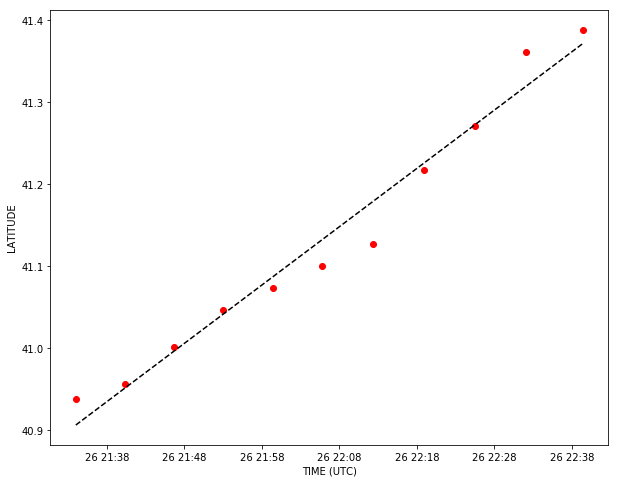

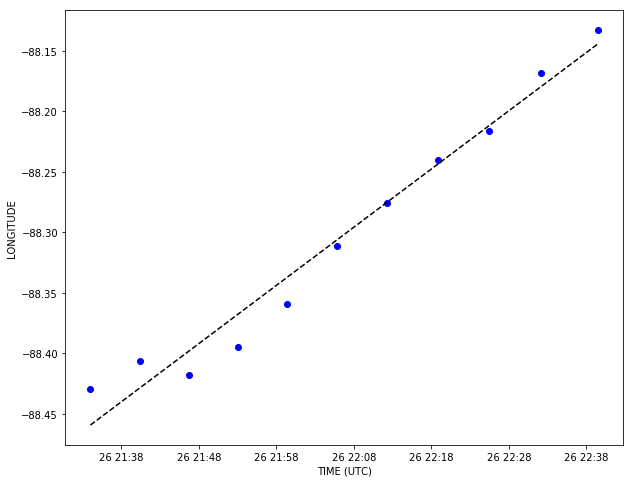

In [20]:
t = (time[:11] - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
x, y = lats[:11], lons[:11]

fit_lat = polyfit(t,x,1)
fit_lon = polyfit(t,y,1)
fit_fn_lon = poly1d(fit_lon)
fit_fn_lat = poly1d(fit_lat)

fig = plt.figure(figsize=(10,8))
plt.plot(time[:11], x, 'ro', time[:11], fit_fn_lat(t), '--k')
plt.xlabel('TIME (UTC)')
plt.ylabel('LATITUDE')
plt.savefig(out_path_dir + '/lat_reg.png', dpi=300)
plt.show()
plt.close()

fig = plt.figure(figsize=(10,8))
plt.plot(time[:11], y, 'bo', time[:11], fit_fn_lon(t), '--k')
plt.xlabel('TIME (UTC)')
plt.ylabel('LONGITUDE')
plt.savefig(out_path_dir + '/lon_reg.png', dpi=300)
plt.show()
plt.close()

In [21]:
def lats_lons(minimum, maximum, interval):
    '''
    Will predict lat/lon for a given time interval.
    Returns time, lat, and lon
    beginning: beginning of the time interval
    end: end of interval
    interval: time interval in minutes
    
    Ex: lats_lons(10, 70, 10) will find the lat/lon 
    for the next hour every 10 minutes.
    '''
    minimum = minimum
    maximum = maximum
    interval = interval
    arr = np.arange(minimum, maximum, interval) 
    my_time = []
    for i in arr:
        my_time.append(time[:10][-1] + np.timedelta64(str(i), 'm'))
    my_new_time = np.array(my_time)
    nts = ((my_new_time - np.datetime64('1970-01-01T00:00:00Z')) 
           / np.timedelta64(1, 's'))
    my_new_lat = fit_fn_lat(nts)
    my_new_lon = fit_fn_lon(nts)
    print(my_new_lon)
    print(my_new_lat)
    return my_new_time, my_new_lat, my_new_lon

In [22]:
my_new_time, my_new_lat, my_new_lon = lats_lons(10,110,10)

[-88.13167465 -88.0835715  -88.03546835 -87.98736519 -87.93926204
 -87.89115889 -87.84305574 -87.79495258 -87.74684943 -87.69874628]
[ 41.39054388  41.46166335  41.53278283  41.60390231  41.67502178
  41.74614126  41.81726074  41.88838021  41.95949969  42.03061917]


/home/jhemedinger/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


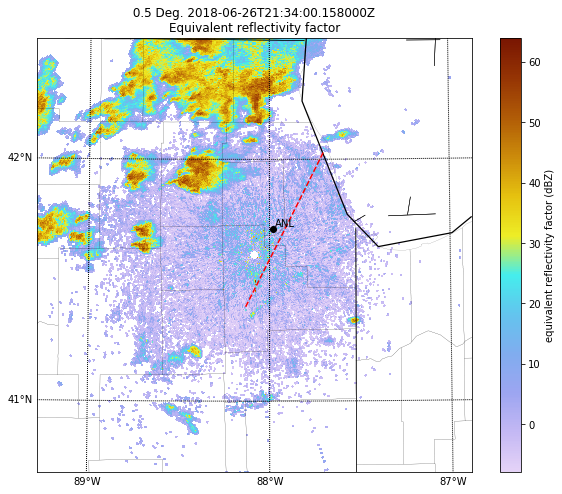

In [36]:
#animating using matplotlib and pyart
def animate(nframe):
    plt.clf()
    localfile = tempfile.NamedTemporaryFile()
    aws_radar.download_file(keys[nframe], localfile.name)
    radar = pyart.io.read(localfile.name)
    display = pyart.graph.RadarMapDisplay(radar)
    # Delete radar after use to save memory.
    del radar
    display.plot_ppi_map('reflectivity', sweep=0, resolution='l',
                         vmin=-8, vmax=64, mask_outside=True, 
                         fig=fig, width=200000, height=200000,
                         cmap=pyart.graph.cm.LangRainbow12)
    display.basemap.drawcounties()
    display.plot_line_geo(my_new_lon, my_new_lat, '--r')
    display.plot_line_geo(lons[:nframe], lats[:nframe], '-k')
    display.plot_point(-87.981810, 41.713969 , label_text='ANL', symbol='ko')
fig = plt.figure(figsize=(10, 8))

anim_klot = animation.FuncAnimation(fig, animate, 
                                    frames=len(keys))
anim_klot.save(out_path_dir + '/ref_track_animation.gif', 
               writer='imagemagick', fps=1)
plt.show()
plt.close()

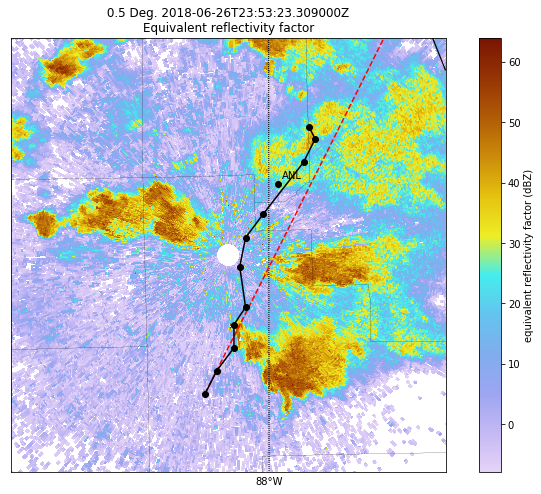

In [29]:

localfile = tempfile.NamedTemporaryFile()

fig=plt.figure(figsize=(12,8))

aws_radar.download_file(keys[-1], localfile.name)
radar = pyart.io.read(localfile.name)
display = pyart.graph.RadarMapDisplay(radar)

display.plot_ppi_map('reflectivity', sweep=0, resolution='l', 
                     vmin=-8, vmax=64, mask_outside=True, width=75000, height=75000, 
                     cmap=pyart.graph.cm.LangRainbow12)
display.basemap.drawcounties()
display.plot_line_geo(my_new_lon, my_new_lat, '--r')
display.plot_line_geo(lons[-11:], lats[-11:], '-ok')
display.plot_point(-87.981810, 41.713969 , label_text='ANL', symbol='ko')
plt.savefig(out_path_dir +'/storm_plot.png', dpi=300)
plt.show()
plt.close()

IndexError: index 10 is out of bounds for axis 0 with size 10

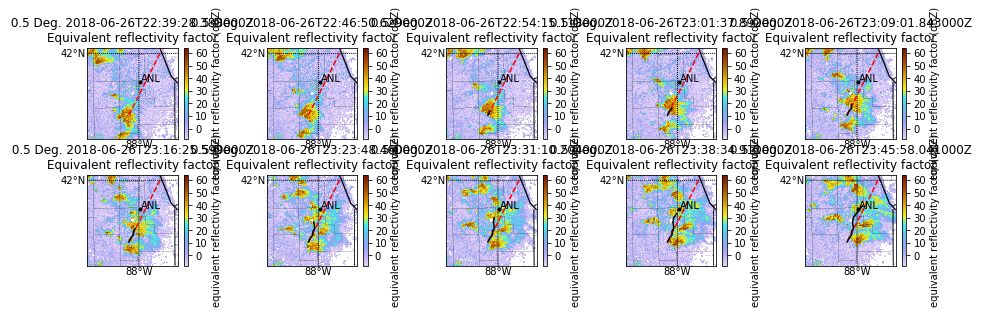

In [30]:
localfile = tempfile.NamedTemporaryFile()
fig, axs = plt.subplots(2,5, figsize=(15, 4), edgecolor='k')
fig.subplots_adjust(hspace = .4, wspace=.511)

axs = axs.ravel()

for i in range(len(keys[-10:])):
    aws_radar.download_file(keys[-10:][i], localfile.name)
    radar = pyart.io.read(localfile.name)
    display = pyart.graph.RadarMapDisplay(radar)
    # Delete radar after use to save memory.
    del radar
    display.plot_ppi_map('reflectivity', ax=axs[i], sweep=0, resolution='l',
                         vmin=-8, vmax=64, mask_outside=True, width=100000, height=100000,
                         cmap=pyart.graph.cm.LangRainbow12)
    display.basemap.drawcounties()
    display.plot_line_geo(my_new_lon, my_new_lat, '--r')
    display.plot_line_geo(lons[-10:][:i], lats[-10:][:i], '-k')
    display.plot_point(-87.981810, 41.713969 , label_text='ANL', symbol='k.')
    font = { 'family' : 'normal',
            'size'   : 16 }

    matplotlib.rc('font', **font)

    matplotlib.rcParams.update({'font.size': 6})
    matplotlib.rcParams.update({'axes.titlesize': 8})
plt.savefig(out_path_dir +'/storm_panel_plot.png', dpi=300)
plt.show()
plt.close()